In [2]:
import numpy as np
import nltk
import os
import string 
import pickle
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from num2words import num2words
from tqdm import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
import math
import heapq
import re
import copy
import random
import pandas as pd
from unidecode import unidecode
from sklearn.manifold import TSNE
from statistics import mode, StatisticsError 
import gc

In [3]:
gc.collect()

0

In [4]:
ps = PorterStemmer()

### Loading Data

In [5]:
path = 'C:\\Users\\shekh\\Desktop\\Shekhar\\IR\\Assignment 1\\20_newsgroups'
folders = []
files = []
docs = []
names = []

#loading folders
for folder in os.listdir(path):
    folders.append(folder)
    
#print(folders)

subset = ['comp.graphics', 'sci.med','talk.politics.misc', 'rec.sport.hockey', 'sci.space']

docsdic = {}
docsdicindex = {}

#loading files from each folder 
for folder in folders:
    if folder in subset:
        newpath = path +'\\'+folder
        for file in tqdm(os.listdir(newpath)):
            try:
                f = open(newpath+'\\'+file,"r")
                #print(doc)
                doc = f.read()
                #adding files to list
                docs.append(doc)
                if folder in docsdic:
                    docsdic[folder].append(doc)
                else:
                    docsdic[folder] = [doc]
                names.append((file,folder))
                f.close()
            except:
                pass
            
      

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 171.52it/s]


In [6]:
def listtodict(keys, values):
    keys = keys.copy()
    values = values.copy()
    dic = {}
    for key in range(len(keys)): 
        for value in values: 
            dic[key] = value
            values.remove(value)
            break  
    return dic

In [7]:
def remove_metadata(documents):
    pos = documents.index('\n\n')
    fixed_docs = documents[pos:]
    return fixed_docs

In [8]:
def apply_proter_stemmer(string):
    for i in range(len(string)):
        string[i] = ps.stem(string[i])
    return string
        

In [9]:
def remove_stopword(string):
    stop_words = set(stopwords.words('english'))
    data = [w for w in string if not w in stop_words]
    return data

In [10]:
def convert_num(string):
    for i in range(len(string)):
        try:
            if(string[i].isnumeric()):
                string[i] = num2words(string[i])
        except:
            continue
    return string

In [11]:
def remove_nonascii(string):
    stripped = (c for c in string if 0 < ord(c) < 127)
    return ''.join(stripped)

In [12]:
def preprocessing(newdataset):
    dataset = newdataset.copy()
    for i in tqdm(range(len(dataset))):
        dataset[i] = dataset[i].lower()
        dataset[i] = remove_nonascii(dataset[i])
        dataset[i] = dataset[i].translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
        dataset[i] = dataset[i].split()
        dataset[i] = remove_stopword(dataset[i])
        dataset[i] = convert_num(dataset[i])
        dataset[i] = apply_proter_stemmer(dataset[i])
    return dataset

In [13]:
def querypreprocessing(stringdata):
    lower = stringdata.lower()
    punc = lower.translate(str.maketrans('','',string.punctuation))
    spl = punc.split()
    removestop = remove_stopword(spl)
    removenum = convert_num(removestop)
    stemmedquery = apply_proter_stemmer(removenum)
    
    for word in stemmedquery:
        if word not in vocab:
            stemmedquery.remove(word)
    
    return stemmedquery

In [14]:
def create_vocabulary(data):
    vocab = set()
    for doc in data:
        for word in doc:
            #print(word)
            vocab.add(word)
    return list(vocab)

In [15]:
def traintest_split(Dic, ratio):
    D = copy.deepcopy(Dic)
    traindic = {}
    trainindex = {}
    testindex = {}
    test = []
    traindata = []
    keys = list(D.keys())
    
    for key in tqdm(range(len(keys))):
        traindic[keys[key]] = random.sample(D[keys[key]],int(len(D[keys[key]])*(ratio/100)))
        traindata.extend(traindic[keys[key]])
        for data in D[keys[key]]:
            if data not in traindic[keys[key]]:
                test.append(data)
                if keys[key] in testindex:
                    testindex[keys[key]].append(D[keys[key]].index(data)+(key*1000))
                else:
                    testindex[keys[key]] = [D[keys[key]].index(data)+(key*1000)]
            else:
                if keys[key] in trainindex:
                    trainindex[keys[key]].append(D[keys[key]].index(data)+(key*1000))
                else:
                    trainindex[keys[key]] = [D[keys[key]].index(data)+(key*1000)]
                
    return traindic, test, trainindex,testindex, traindata


In [16]:
def create_dataframe(vocab, data):
    df = pd.DataFrame()
    df['vocab'] = vocab
    
    
    tfall = []
    
    for i in tqdm(range(len(data))):
        tf1 = []
        for word in vocab:
            tf1.append(termfreq(data[i],word))
        #print(len(tf1))
        tfall.append(tf1)
    #print(tfall)
    
    for i in tqdm(range(len(tfall))):
        df.insert(i+1, i, tfall[i],allow_duplicates = False)
    
    df.set_index('vocab', inplace = True)
    
    return df

In [17]:
def get_mutual_information(class_tf_idf_series, class_tf_df_list):
    words = class_tf_idf_series.index
    Mutual_Information = {}
    Mutual_Information_each_class = pd.DataFrame()
    
    class_tf = pd.concat(class_tf_df_list, axis=1)
    class_tf.replace(np.nan, 0, inplace=True)
#     display(class_tf[class_tf>0])
    
    for i, class_tf_1 in tqdm(enumerate(class_tf_df_list)):
        in_class_df = class_tf.iloc[:, i*len(class_tf_1.columns):(i+1)*len(class_tf_1.columns)]
        not_in_class_df = class_tf.drop(in_class_df.columns, axis=1)
        
        # number of docs containing term and present in the class
        n11 = in_class_df[in_class_df>0].count(axis=1)

        # number of docs present in the class which doesn't have the term
        n01 = in_class_df[in_class_df == 0].count(axis=1)

        # number of docs containing term but does not present in the class
        n10 = not_in_class_df[not_in_class_df>0].count(axis=1)

        # number of docs doesn't have the term and not present in class
        n00 = not_in_class_df[not_in_class_df == 0].count(axis=1)
        
        n = n11+n01+n10+n00
        a = (n11/n)*np.log2((n*n11)/((n10+n11)*(n01+n11)))
        b = (n01/n)*np.log2((n*n01)/((n00+n01)*(n01+n11)))
        c = (n10/n)*np.log2((n*n10)/((n10+n11)*(n10+n00)))
        d = (n00/n)*np.log2((n*n00)/((n01+n00)*(n00+n10)))
            
        a.replace(np.nan, 0, inplace=True)
        b.replace(np.nan, 0, inplace=True)
        c.replace(np.nan, 0, inplace=True)
        d.replace(np.nan, 0, inplace=True)
    
        MI = a+b+c+d
        Mutual_Information_each_class = pd.concat([Mutual_Information_each_class, MI], axis=1)

    Mutual_Information_each_class.columns = class_tf_idf_series.columns
        
    return Mutual_Information_each_class

In [18]:
def termfreq(data, word):
    if data.count(word) == 0:
        return 0.0
    else:
        return 1+(math.log10(data.count(word)))
        #return(data.count(word)/len(data))

In [19]:
def accuracy(docs, result, data):
    correct = 0
    
    for i,j in zip(docs,result):
        m = []
        if i in data[j]:
            correct += 1
            m.append(1)
        else:
            m.append(0)
        
    return(correct/len(result))

In [20]:
def tfidf_feature_selection(data):
    termsinclass = []
    wholedic = {}
    for key in data.keys():
        terms = []
        for docs in data[key]:
            terms.extend(docs)
            wholedic[key] = terms
        termsinclass.append(terms)
   # print(len(termsinclass))
    
    vocab = create_vocabulary(termsinclass)
    
    df = pd.DataFrame(columns = list(data.keys()))
    
    df['vocab'] = vocab
    df.set_index('vocab', inplace = True)
    #print(vocab == df.index.values)
    #termfreq(wholedic, "")
    keys = list(wholedic.keys())
    #print(keys)
    for key in keys:
        series = []
        for term in tqdm(df.index.values):
            series.append(termfreq(wholedic.get(key), term))
        df.loc[:,key] = series
    
    nonzero = np.count_nonzero(df,axis = 1) 
    #print(nonzero[3])
    idf = []
    for i in tqdm(range(len(nonzero))):
        #print(nonzero[i])
        idf.append(1/(1+(math.log10(df.shape[1]/nonzero[i]))))
    
    df['idf'] = idf
    
    return df

In [21]:
def l1(x):
    x_new = x/np.sqrt(np.sum(np.square(x)))
    return x_new 

In [22]:
def create_tfidf(df1):
    df = df1.copy()
    df.iloc[:, 0:-1] = df.iloc[:, 0:-1].mul(df.iloc[:, -1], axis=0)
    #print(df)
    return df

In [23]:
def select_top(dataframe, percent):
    featuresdataframe = dataframe.copy()
    if 'idf' in featuresdataframe.columns:
        featuresdataframe = featuresdataframe.drop(labels = 'idf', axis = 1)
    feat = []
    for column in featuresdataframe.columns:
        feat.append(featuresdataframe[column].sort_values(ascending = False, axis=0).index.tolist())
        #print(featuresdataframe[column].sort_values(ascending = False, axis=0).index)
    #print(len(feat[1]))
    
    for i in range(len(feat)):
        feat[i] = feat[i][:int(len(feat[i])*(percent/100))]
    #print(len(feat[1]))
    
    return feat

In [205]:
def reduce_docs(features, dic):
    data = copy.deepcopy(dic)
#     for key in data.keys():
#         print(len(data[key][1]))
    
    for (i,key) in zip(features, data.keys()):
        
        newlist = []
        for j in data[key]:
            #print(i)
            new = []
            for term in j:
                if term in i:
                    new.append(term)
            newlist.append(new)
       # print(len(newlist))
        data[key] = newlist
                
    return data

In [25]:
def confusion_matrix(D, result, testdata):
    compgraphic = []
    hockey = []
    scimed = []
    space = []
    politics = []
    
    keys = list(D.keys())
    #print(keys)
    
    for i in range(len(result)):
        if result[i] =='comp.graphics':
            compgraphic.append(i)
        elif result[i] == 'sci.med':
            scimed.append(i)
        elif result[i] == 'talk.politics.misc':
            politics.append(i)
        elif result[i] == 'sci.space':
            space.append(i)
        else:
            hockey.append(i)
    comp = np.zeros(5)
    hock = np.zeros(5)
    sci = np.zeros(5)
    spa = np.zeros(5)
    pol = np.zeros(5)
    for i in compgraphic:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                comp[j] += 1
    
    for i in hockey:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                hock[j] += 1

    for i in scimed:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                sci[j] += 1
                
    for i in space:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                spa[j] += 1
                
    for i in politics:
        for j in range(len(keys)):
            if testdata[i] in D[keys[j]]:
                #print(keys[j])
                pol[j] += 1

    confusion = np.array([comp, hock,sci,spa,pol], np.int32)
    
    confusiondf = pd.DataFrame(data = confusion, index = keys, columns = ['comp.graphics-pred', 'rec.sport.hockey-pred', 'sci.med-pred', 'sci.space-pred', 'talk.politics.misc-pred'])
    
    return confusiondf

In [26]:
def polling(k, similarity, train_index):
    index = list(similarity.nlargest(k).index)
    selected = []
    
    for i in index:
        for key in train_index.keys():
            if i in train_index[key]:
                selected.append(key)
                
    try:
        result = mode(selected)
        return result
    except StatisticsError:
        return selected[0]

In [27]:
def knn(train_df, test_df,k, train_index):
    train = copy.deepcopy(train_df)
    test = copy.deepcopy(test_df)
    
#     trainnormalised = train.apply(lambda col: l1(col),axis = 0)
#     testnormalised = test.apply(lambda col: l1(col),axis = 0)
    
    traintranspose = train.transpose()
#    print( test.shape,traintranspose.shape)
    similarities = traintranspose.dot(test)
    result = []
#     print(type(similarities[0]))
    for column in tqdm(similarities.columns):
        result.append(polling(k,similarities[column],train_index))
    
    return result

In [28]:
docsdic.keys()

dict_keys(['comp.graphics', 'rec.sport.hockey', 'sci.med', 'sci.space', 'talk.politics.misc'])

In [29]:
idtoname = listtodict(docs, names)

### Performing text preproccesing on all docs in each class

In [30]:
for key in docsdic.keys():
    docsdic[key] = preprocessing(docsdic[key])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.83it/s]


### Splitting Data into Train and test set of specified ratios

In [42]:
train_data_dic80, test_data20, train_index80,test_index20, train_data80 = traintest_split(docsdic, 80)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 79.42it/s]


In [58]:
train_data_dic70, test_data30, train_index70,test_index30, train_data70 = traintest_split(docsdic, 70)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.08it/s]


In [44]:
train_data_dic50, test_data50, train_index50,test_index50, train_data50 = traintest_split(docsdic, 50)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 81.42it/s]


In [60]:
# print(len(train_data80), len(train_data70), len(train_data50))
# print(len(test_data20),len(test_data30),len(test_data50))

4000 3500 2500
1000 1500 2500


In [ ]:
#train_index80['sci.med']

## TF-IDF

### Calculating TF-IDF feature selection for each split of data
please be patient this will take time 

In [61]:
tfidffeatures80 = tfidf_feature_selection(train_data_dic80)

100%|████████████████████████████████████████████████████████████████████████| 49723/49723 [00:00<00:00, 441158.73it/s]


In [62]:
tfidffeatures70 = tfidf_feature_selection(train_data_dic70)

100%|████████████████████████████████████████████████████████████████████████| 46221/46221 [00:00<00:00, 501384.75it/s]


In [63]:
tfidffeatures50 = tfidf_feature_selection(train_data_dic50)

100%|████████████████████████████████████████████████████████████████████████| 38079/38079 [00:00<00:00, 513579.16it/s]


In [64]:
tfidfdataframe80 = create_tfidf(tfidffeatures80)
tfidfdataframe70 = create_tfidf(tfidffeatures70)
tfidfdataframe50 = create_tfidf(tfidffeatures50)

### Selecting top 30% of the features

In [65]:
selected_features80 = select_top(tfidfdataframe80, 30)
selected_features70 = select_top(tfidfdataframe70, 30)
selected_features50 = select_top(tfidfdataframe50, 30)

### Removing word from docs that were not selected in feature selection

In [66]:
reducedtrain80 = reduce_docs(selected_features80, train_data_dic80)
reducedtrain70 = reduce_docs(selected_features70, train_data_dic70)
reducedtrain50 = reduce_docs(selected_features50, train_data_dic50)

### Creating vocabulary for each train set

In [67]:
vocabuarytrain80 = []
vm = []
for key in reducedtrain80.keys():
    vm.extend(create_vocabulary(reducedtrain80[key]))
vocabuarytrain80 = list(set(vm))

vocabuarytrain70 = []
vm2 = []
for key in reducedtrain70.keys():
    vm2.extend(create_vocabulary(reducedtrain70[key]))
vocabuarytrain70 = list(set(vm2))

vocabuarytrain50 = []
vm3 = []
for key in reducedtrain50.keys():
    vm3.extend(create_vocabulary(reducedtrain50[key]))
vocabuarytrain50 = list(set(vm3))

print(len(vocabuarytrain80),len(vocabuarytrain70),len(vocabuarytrain50))

44050 48919 50711


In [69]:
reducedtraindata80 = []
for key in reducedtrain80.keys():
    for j in reducedtrain80[key]:
        reducedtraindata80.append(j)

reducedtraindata70 = []
for key in reducedtrain70.keys():
    for j in reducedtrain70[key]:
        reducedtraindata70.append(j)
        
reducedtraindata50 = []
for key in reducedtrain50.keys():
    for j in reducedtrain50[key]:
        reducedtraindata50.append(j)

### Creating Dataframe for KNN calculation

In [70]:
tfdataframetrain80 = create_dataframe(vocabuarytrain80,reducedtraindata80)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:44<00:00, 90.20it/s]


In [71]:
tfdataframetrain70 = create_dataframe(vocabuarytrain70,reducedtraindata70)

100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:38<00:00, 90.18it/s]


In [72]:
tfdataframetrain50 = create_dataframe(vocabuarytrain50,reducedtraindata50)

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 110.29it/s]


In [73]:
tfdataframetest20 = create_dataframe(vocabuarytrain80,test_data20)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 192.48it/s]


In [74]:
tfdataframetest30 = create_dataframe(vocabuarytrain70,test_data30)

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:10<00:00, 147.11it/s]


In [75]:
tfdataframetest50 = create_dataframe(vocabuarytrain50,test_data50)

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:23<00:00, 106.99it/s]


In [78]:
tftrainindex80 = []
for key in train_index80.keys():
    for i in train_index80[key]:
        tftrainindex80.append(i)
tftrainindex70 = []
for key in train_index70.keys():
    for i in train_index70[key]:
        tftrainindex70.append(i)
        
tftrainindex50 = []        
for key in train_index50.keys():
    for i in train_index50[key]:
        tftrainindex50.append(i)
#print(len(tftrainindex80),len(tftrainindex70),len(tftrainindex50))

4000 3500 2500


In [79]:
#print(len(tftrainindex80),len(tftrainindex70),len(tftrainindex50))

4000 3500 2500


In [80]:
tfdataframetrain80.columns = tftrainindex80
tfdataframetrain70.columns = tftrainindex70
tfdataframetrain50.columns = tftrainindex50

### Apply L1 norm to both Test DataFrame and Train DataFrame

In [81]:
trainnormalised80 = tfdataframetrain80.apply(lambda col: l1(col),axis = 0)
testnormalised20 = tfdataframetest20.apply(lambda col: l1(col),axis = 0)
trainnormalised70 = tfdataframetrain70.apply(lambda col: l1(col),axis = 0)
testnormalised30 = tfdataframetest30.apply(lambda col: l1(col),axis = 0)
trainnormalised50 = tfdataframetrain50.apply(lambda col: l1(col),axis = 0)
testnormalised50 = tfdataframetest50.apply(lambda col: l1(col),axis = 0)

In [82]:
print(type(test_data20))

<class 'list'>


In [145]:
acculist8020 = []

### Run KNN on each split of data for K = 1,3,5
This will only take a few seconds

#### 80-20 Split

In [146]:
result80k1 = knn(trainnormalised80,testnormalised20,1, train_index80)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1186.49it/s]


In [147]:
result80k3 = knn(trainnormalised80,testnormalised20,3, train_index80)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1060.70it/s]


In [148]:
result80k5 = knn(trainnormalised80,testnormalised20,5, train_index80)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 927.04it/s]


In [150]:
acculist8020.append(accuracy(test_data20,result80k1,docsdic))
acculist8020.append(accuracy(test_data20,result80k3,docsdic))
acculist8020.append(accuracy(test_data20,result80k5,docsdic))

### Print accuracy with Confusion Matrix

In [151]:
print("K=1")
print("Accuracy with tfidf feature selection over 80-20 split",acculist8020[0])
confusion_matrix(docsdic,result80k1,test_data20)

K=1
Accuracy with tfidf feature selection over 80-20 split 0.944


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,182,4,12,4,1
rec.sport.hockey,3,195,3,3,0
sci.med,10,1,178,1,1
sci.space,4,0,4,192,1
talk.politics.misc,2,0,3,1,197


In [152]:
print("K=3")
print("Accuracy with tfidf feature selection over 80-20 split",acculist8020[1])
confusion_matrix(docsdic,result80k3,test_data20)

K=3
Accuracy with tfidf feature selection over 80-20 split 0.956


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,188,1,8,3,1
rec.sport.hockey,4,198,3,3,1
sci.med,3,1,183,1,3
sci.space,4,0,3,192,0
talk.politics.misc,2,0,3,2,195


In [153]:
print("K=5")
print("Accuracy with tfidf feature selection over 80-20 split",acculist8020[2])
confusion_matrix(docsdic,result80k5,test_data20)

K=5
Accuracy with tfidf feature selection over 80-20 split 0.968


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,195,4,3,4,1
rec.sport.hockey,1,196,3,2,1
sci.med,3,0,189,1,2
sci.space,0,0,3,193,1
talk.politics.misc,2,0,2,1,195


In [158]:
print(acculist8020)

[0.944, 0.956, 0.968]


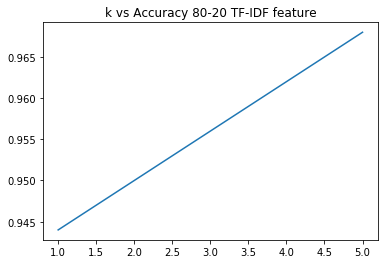

In [264]:
plt.plot([1,3,5],acculist8020)
plt.title("k vs Accuracy 80-20 TF-IDF feature")
plt.show()

#### 70-30 Split

In [154]:
acculist7030 = []

In [155]:
result70k1 = knn(trainnormalised70,testnormalised30,1, train_index70)

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1119.11it/s]


In [156]:
result70k3 = knn(trainnormalised70,testnormalised30,3, train_index70)

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1191.22it/s]


In [157]:
result70k5 = knn(trainnormalised70,testnormalised30,5, train_index70)

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:03<00:00, 458.88it/s]


In [159]:
acculist7030.append(accuracy(test_data30,result70k1,docsdic))
acculist7030.append(accuracy(test_data30,result70k3,docsdic))
acculist7030.append(accuracy(test_data30,result70k5,docsdic))

In [161]:
print("K=1")
print("Accuracy with tfidf feature selection over 70-30 split",acculist7030[0])
confusion_matrix(docsdic,result70k1,test_data30)

K=1
Accuracy with tfidf feature selection over 70-30 split 0.94


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,277,3,21,6,3
rec.sport.hockey,8,289,4,1,2
sci.med,14,7,268,5,3
sci.space,2,1,5,287,3
talk.politics.misc,1,0,5,1,289


In [162]:
print("K=3")
print("Accuracy with tfidf feature selection over 70-30 split",acculist7030[1])
confusion_matrix(docsdic,result70k3,test_data30)

K=3
Accuracy with tfidf feature selection over 70-30 split 0.9473333333333334


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,280,3,17,8,2
rec.sport.hockey,6,292,3,0,2
sci.med,15,4,276,8,2
sci.space,1,1,3,282,3
talk.politics.misc,0,0,4,2,291


In [163]:
print("K=5")
print("Accuracy with tfidf feature selection over 70-30 split",acculist7030[2])
confusion_matrix(docsdic,result70k5,test_data30)

K=5
Accuracy with tfidf feature selection over 70-30 split 0.9606666666666667


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,287,1,11,6,2
rec.sport.hockey,6,294,2,0,3
sci.med,9,4,285,9,1
sci.space,0,1,2,283,2
talk.politics.misc,0,0,3,2,292


In [164]:
print(acculist7030)

[0.94, 0.9473333333333334, 0.9606666666666667]


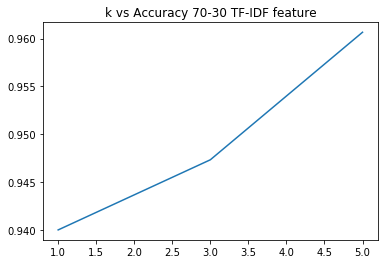

In [263]:
plt.plot([1,3,5],acculist7030)
plt.title("k vs Accuracy 70-30 TF-IDF feature")
plt.show()

#### 50-50 Split

In [165]:
acculist5050 = []

In [166]:
result50k1 = knn(trainnormalised50,testnormalised50,1, train_index50)

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:01<00:00, 1343.11it/s]


In [167]:
result50k3 = knn(trainnormalised50,testnormalised50,3, train_index50)

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1151.97it/s]


In [168]:
result50k5 = knn(trainnormalised50,testnormalised50,5, train_index50)

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1159.08it/s]


In [169]:
acculist5050.append(accuracy(test_data50,result50k1,docsdic))
acculist5050.append(accuracy(test_data50,result50k3,docsdic))
acculist5050.append(accuracy(test_data50,result50k5,docsdic))

In [262]:
print("K=1")
print("Accuracy with tfidf feature selection over 50-50 split",acculist5050[0])
confusion_matrix(docsdic,result50k1,test_data50)

K=1
Accuracy with tfidf feature selection over 50-50 split 0.9312


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,462,10,33,11,4
rec.sport.hockey,10,479,7,6,8
sci.med,21,4,445,9,4
sci.space,10,6,9,461,4
talk.politics.misc,1,1,10,15,481


In [261]:
print("K=3")
print("Accuracy with tfidf feature selection over 50-50 split",acculist5050[1])
confusion_matrix(docsdic,result50k3,test_data50)

K=3
Accuracy with tfidf feature selection over 50-50 split 0.942


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,479,10,33,13,4
rec.sport.hockey,5,483,6,7,6
sci.med,11,3,444,8,2
sci.space,6,3,11,464,4
talk.politics.misc,3,1,10,10,485


In [260]:
print("K=5")
print("Accuracy with tfidf feature selection over 50-50 split",acculist5050[2])
confusion_matrix(docsdic,result50k5,test_data50)

K=5
Accuracy with tfidf feature selection over 50-50 split 0.95


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,485,7,35,11,3
rec.sport.hockey,3,490,5,7,7
sci.med,8,2,448,12,0
sci.space,6,1,8,464,3
talk.politics.misc,2,0,8,8,488


In [129]:
print(acculist5050)

[0.9312, 0.9312, 0.942]


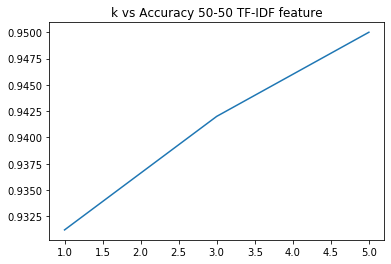

In [259]:
plt.plot([1,3,5],acculist5050)
plt.title("k vs Accuracy 50-50 TF-IDF feature")
plt.show()

### K vs Accuracy for each split of data , K = 1,3,5 with TF-IDF

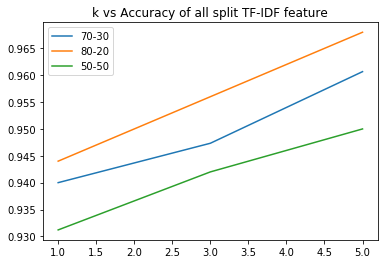

In [270]:
plt.plot([1,3,5],acculist7030, label = '70-30')
plt.plot([1,3,5],acculist8020, label = '80-20')
plt.plot([1,3,5],acculist5050, label = '50-50')
plt.legend()
plt.title("k vs Accuracy of all split TF-IDF feature")
plt.show()

In [ ]:
# vocabularytrain80 = create_vocabulary(train_data80)

In [179]:
vocabcomp = create_vocabulary(docsdic['comp.graphics'])
vocabhockey = create_vocabulary(docsdic['rec.sport.hockey'])
vocabscimed = create_vocabulary(docsdic['sci.med'])
vocabscispace = create_vocabulary(docsdic['sci.space'])
vocabpolitics = create_vocabulary(docsdic['talk.politics.misc'])

In [180]:
dfclasscomp = create_dataframe(vocabcomp,docsdic['comp.graphics'])
dfclasshock = create_dataframe(vocabhockey,docsdic['rec.sport.hockey'])
dfclassmed = create_dataframe(vocabscimed,docsdic['sci.med'])
dfclassspace = create_dataframe(vocabscispace,docsdic['sci.space'])
dfclasspol = create_dataframe(vocabpolitics,docsdic['talk.politics.misc'])

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 350.11it/s]


In [181]:
dflist = []
dflist.append(dfclasscomp)
dflist.append(dfclasshock)
dflist.append(dfclassmed)
dflist.append(dfclassspace)
dflist.append(dfclasspol)

## Mutual Information

### Calculating Mutual Information for each split of Train Data

In [176]:
mitffeatures80 = copy.deepcopy(tfidffeatures80)
mitffeatures80 = mitffeatures80.drop(labels = 'idf', axis = 1)
mitffeatures70 = copy.deepcopy(tfidffeatures70)
mitffeatures70 = mitffeatures70.drop(labels = 'idf', axis = 1)
mitffeatures50 = copy.deepcopy(tfidffeatures50)
mitffeatures50 = mitffeatures50.drop(labels = 'idf', axis = 1)

In [177]:
import warnings
warnings.filterwarnings("ignore")

In [182]:
midf80 = get_mutual_information(mitffeatures80,dflist)

5it [00:16,  3.40s/it]


In [189]:
midf70 = get_mutual_information(mitffeatures70, dflist)

5it [00:19,  3.89s/it]


In [188]:
midf50 = get_mutual_information(mitffeatures50, dflist)

5it [00:17,  3.42s/it]


### Selecting top 30% of the word from the features

In [195]:
midf80selected = select_top(midf80, 30)

In [196]:
midf70selected = select_top(midf70, 30)

In [197]:
midf50selected = select_top(midf50, 30)

#### Removing words from the docs that were not selected in the feature selection

In [206]:
reducedtrain80mi = reduce_docs(midf80selected, train_data_dic80)
# reducedtrain70 = reduce_docs(midf70selected, train_data_dic70)
# reducedtrain50 = reduce_docs(midf50selected, train_data_dic50)

In [207]:
reducedtrain70mi = reduce_docs(midf70selected, train_data_dic70)

In [208]:
reducedtrain50mi = reduce_docs(midf50selected, train_data_dic50)

In [209]:
vocabuarytrain80mi = []
vmi = []
for key in reducedtrain80mi.keys():
    vmi.extend(create_vocabulary(reducedtrain80mi[key]))
vocabuarytrain80mi = list(set(vmi))

vocabuarytrain70mi = []
vmi2 = []
for key in reducedtrain70mi.keys():
    vmi2.extend(create_vocabulary(reducedtrain70mi[key]))
vocabuarytrain70mi = list(set(vmi2))

vocabuarytrain50mi = []
vmi3 = []
for key in reducedtrain50.keys():
    vmi3.extend(create_vocabulary(reducedtrain50mi[key]))
vocabuarytrain50mi = list(set(vmi3))

#print(len(vocabuarytrain80mi),len(vocabuarytrain70mi),len(vocabuarytrain50mi))

15006 14029 11620


In [211]:
reducedtraindata80mi = []
for key in reducedtrain80mi.keys():
    for j in reducedtrain80mi[key]:
        reducedtraindata80mi.append(j)

reducedtraindata70mi = []
for key in reducedtrain70mi.keys():
    for j in reducedtrain70mi[key]:
        reducedtraindata70mi.append(j)
        
reducedtraindata50mi = []
for key in reducedtrain50mi.keys():
    for j in reducedtrain50mi[key]:
        reducedtraindata50mi.append(j)

### Create Test and Train Dataframe for KNN Calculation
this take only a few minutes

In [212]:
tfdataframetrain80mi = create_dataframe(vocabuarytrain80mi,reducedtraindata80mi)



  0%|                                                                                         | 0/4000 [00:00<?, ?it/s]

  0%|                                                                                 | 6/4000 [00:00<01:15, 52.57it/s]

  0%|▏                                                                               | 11/4000 [00:00<01:17, 51.17it/s]

  0%|▎                                                                               | 18/4000 [00:00<01:13, 53.95it/s]

  1%|▌                                                                               | 25/4000 [00:00<01:11, 55.32it/s]

  1%|▌                                                                               | 31/4000 [00:00<01:12, 54.51it/s]

  1%|▊                                                                               | 39/4000 [00:00<01:08, 57.88it/s]

  1%|▉                                                                               | 45/4000 [00:00<01:17, 51.25it/s]

  1%|█                        

 10%|███████▊                                                                       | 398/4000 [00:08<01:12, 49.77it/s]

 10%|████████                                                                       | 406/4000 [00:09<01:04, 55.52it/s]

 10%|████████▏                                                                      | 414/4000 [00:09<01:00, 59.19it/s]

 11%|████████▎                                                                      | 421/4000 [00:09<01:09, 51.27it/s]

 11%|████████▍                                                                      | 427/4000 [00:09<01:07, 52.72it/s]

 11%|████████▌                                                                      | 433/4000 [00:09<01:07, 52.54it/s]

 11%|████████▋                                                                      | 441/4000 [00:09<01:02, 56.69it/s]

 11%|████████▊                                                                      | 447/4000 [00:09<01:02, 57.26it/s]

 11%|████████▉                  

 20%|████████████████▏                                                              | 817/4000 [00:18<01:06, 48.07it/s]

 21%|████████████████▎                                                              | 823/4000 [00:18<01:04, 48.88it/s]

 21%|████████████████▎                                                              | 829/4000 [00:18<01:08, 46.20it/s]

 21%|████████████████▍                                                              | 834/4000 [00:18<01:06, 47.27it/s]

 21%|████████████████▌                                                              | 839/4000 [00:18<01:15, 41.95it/s]

 21%|████████████████▋                                                              | 844/4000 [00:19<01:12, 43.61it/s]

 21%|████████████████▊                                                              | 849/4000 [00:19<01:12, 43.66it/s]

 21%|████████████████▊                                                              | 854/4000 [00:19<01:09, 45.08it/s]

 21%|████████████████▉          

 30%|███████████████████████▎                                                      | 1194/4000 [00:26<01:53, 24.75it/s]

 30%|███████████████████████▍                                                      | 1201/4000 [00:26<01:32, 30.35it/s]

 30%|███████████████████████▌                                                      | 1206/4000 [00:27<01:22, 33.79it/s]

 30%|███████████████████████▋                                                      | 1212/4000 [00:27<01:13, 38.00it/s]

 30%|███████████████████████▋                                                      | 1217/4000 [00:27<01:09, 40.16it/s]

 31%|███████████████████████▊                                                      | 1222/4000 [00:27<01:08, 40.70it/s]

 31%|███████████████████████▉                                                      | 1227/4000 [00:27<01:12, 38.17it/s]

 31%|████████████████████████                                                      | 1232/4000 [00:27<01:07, 41.08it/s]

 31%|████████████████████████▏  

 39%|██████████████████████████████▎                                               | 1552/4000 [00:35<00:51, 47.22it/s]

 39%|██████████████████████████████▎                                               | 1557/4000 [00:35<00:55, 44.05it/s]

 39%|██████████████████████████████▍                                               | 1562/4000 [00:35<01:03, 38.68it/s]

 39%|██████████████████████████████▌                                               | 1567/4000 [00:35<01:08, 35.50it/s]

 39%|██████████████████████████████▋                                               | 1573/4000 [00:36<01:09, 34.88it/s]

 39%|██████████████████████████████▊                                               | 1577/4000 [00:36<01:08, 35.49it/s]

 40%|██████████████████████████████▉                                               | 1584/4000 [00:36<01:02, 38.53it/s]

 40%|██████████████████████████████▉                                               | 1589/4000 [00:36<01:07, 35.59it/s]

 40%|███████████████████████████

 48%|█████████████████████████████████████▋                                        | 1932/4000 [00:43<00:40, 50.68it/s]

 48%|█████████████████████████████████████▊                                        | 1938/4000 [00:44<00:42, 48.92it/s]

 49%|█████████████████████████████████████▉                                        | 1944/4000 [00:44<00:41, 49.80it/s]

 49%|██████████████████████████████████████                                        | 1950/4000 [00:44<00:39, 52.44it/s]

 49%|██████████████████████████████████████▏                                       | 1956/4000 [00:44<00:39, 52.02it/s]

 49%|██████████████████████████████████████▎                                       | 1962/4000 [00:44<00:46, 43.80it/s]

 49%|██████████████████████████████████████▍                                       | 1968/4000 [00:44<00:46, 43.43it/s]

 49%|██████████████████████████████████████▍                                       | 1973/4000 [00:44<00:47, 42.79it/s]

 49%|███████████████████████████

 58%|████████████████████████████████████████████▉                                 | 2305/4000 [00:52<00:55, 30.52it/s]

 58%|█████████████████████████████████████████████                                 | 2310/4000 [00:53<00:49, 34.14it/s]

 58%|█████████████████████████████████████████████▏                                | 2315/4000 [00:53<00:48, 35.03it/s]

 58%|█████████████████████████████████████████████▎                                | 2322/4000 [00:53<00:41, 40.29it/s]

 58%|█████████████████████████████████████████████▍                                | 2327/4000 [00:53<00:42, 39.27it/s]

 58%|█████████████████████████████████████████████▍                                | 2332/4000 [00:53<00:42, 38.81it/s]

 58%|█████████████████████████████████████████████▌                                | 2337/4000 [00:53<00:54, 30.61it/s]

 59%|█████████████████████████████████████████████▋                                | 2342/4000 [00:53<00:48, 33.95it/s]

 59%|███████████████████████████

 67%|███████████████████████████████████████████████████▉                          | 2666/4000 [01:01<00:34, 39.08it/s]

 67%|████████████████████████████████████████████████████                          | 2672/4000 [01:01<00:31, 42.23it/s]

 67%|████████████████████████████████████████████████████▏                         | 2678/4000 [01:01<00:29, 44.77it/s]

 67%|████████████████████████████████████████████████████▎                         | 2685/4000 [01:01<00:26, 48.82it/s]

 67%|████████████████████████████████████████████████████▍                         | 2691/4000 [01:01<00:25, 50.97it/s]

 67%|████████████████████████████████████████████████████▌                         | 2697/4000 [01:01<00:25, 51.37it/s]

 68%|████████████████████████████████████████████████████▋                         | 2704/4000 [01:01<00:23, 54.15it/s]

 68%|████████████████████████████████████████████████████▊                         | 2710/4000 [01:01<00:23, 55.40it/s]

 68%|███████████████████████████

 76%|███████████████████████████████████████████████████████████▎                  | 3044/4000 [01:09<00:19, 48.96it/s]

 76%|███████████████████████████████████████████████████████████▍                  | 3051/4000 [01:09<00:18, 51.96it/s]

 76%|███████████████████████████████████████████████████████████▌                  | 3057/4000 [01:09<00:18, 51.81it/s]

 77%|███████████████████████████████████████████████████████████▋                  | 3063/4000 [01:09<00:19, 47.81it/s]

 77%|███████████████████████████████████████████████████████████▊                  | 3069/4000 [01:09<00:20, 45.54it/s]

 77%|███████████████████████████████████████████████████████████▉                  | 3076/4000 [01:09<00:18, 50.12it/s]

 77%|████████████████████████████████████████████████████████████                  | 3082/4000 [01:09<00:26, 34.50it/s]

 77%|████████████████████████████████████████████████████████████▏                 | 3088/4000 [01:10<00:24, 37.27it/s]

 77%|███████████████████████████

 85%|█████████████████████████████████████████████████████████████████▉            | 3384/4000 [01:17<00:16, 37.01it/s]

 85%|██████████████████████████████████████████████████████████████████            | 3389/4000 [01:18<00:15, 40.03it/s]

 85%|██████████████████████████████████████████████████████████████████▏           | 3394/4000 [01:18<00:14, 41.12it/s]

 85%|██████████████████████████████████████████████████████████████████▎           | 3400/4000 [01:18<00:13, 43.85it/s]

 85%|██████████████████████████████████████████████████████████████████▍           | 3405/4000 [01:18<00:13, 45.28it/s]

 85%|██████████████████████████████████████████████████████████████████▌           | 3411/4000 [01:18<00:12, 45.46it/s]

 85%|██████████████████████████████████████████████████████████████████▋           | 3417/4000 [01:18<00:12, 47.25it/s]

 86%|██████████████████████████████████████████████████████████████████▋           | 3422/4000 [01:18<00:13, 43.79it/s]

 86%|███████████████████████████

 93%|████████████████████████████████████████████████████████████████████████▍     | 3714/4000 [01:26<00:06, 42.89it/s]

 93%|████████████████████████████████████████████████████████████████████████▌     | 3719/4000 [01:26<00:06, 44.68it/s]

 93%|████████████████████████████████████████████████████████████████████████▋     | 3725/4000 [01:26<00:06, 45.19it/s]

 93%|████████████████████████████████████████████████████████████████████████▋     | 3730/4000 [01:27<00:10, 26.63it/s]

 93%|████████████████████████████████████████████████████████████████████████▊     | 3737/4000 [01:27<00:08, 32.03it/s]

 94%|████████████████████████████████████████████████████████████████████████▉     | 3743/4000 [01:27<00:06, 37.24it/s]

 94%|█████████████████████████████████████████████████████████████████████████     | 3748/4000 [01:27<00:06, 40.20it/s]

 94%|█████████████████████████████████████████████████████████████████████████▏    | 3753/4000 [01:27<00:06, 39.28it/s]

 94%|███████████████████████████

 11%|████████▋                                                                     | 446/4000 [00:00<00:06, 557.90it/s]

 12%|█████████▋                                                                    | 499/4000 [00:00<00:07, 476.94it/s]

 14%|███████████▏                                                                  | 576/4000 [00:01<00:06, 535.95it/s]

 16%|████████████▎                                                                 | 632/4000 [00:01<00:07, 479.14it/s]

 17%|█████████████▌                                                                | 694/4000 [00:01<00:07, 429.59it/s]

 19%|███████████████▏                                                              | 776/4000 [00:01<00:06, 494.62it/s]

 21%|████████████████▏                                                             | 832/4000 [00:01<00:07, 423.73it/s]

 22%|█████████████████▍                                                            | 892/4000 [00:01<00:08, 378.02it/s]

 24%|██████████████████▊        

 98%|███████████████████████████████████████████████████████████████████████████▋ | 3931/4000 [00:16<00:00, 146.96it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:16<00:00, 237.00it/s]


In [213]:
tfdataframetrain70mi = create_dataframe(vocabuarytrain70mi,reducedtraindata70mi)



  0%|                                                                                         | 0/3500 [00:00<?, ?it/s]

  0%|▏                                                                                | 6/3500 [00:00<01:05, 53.55it/s]

  0%|▎                                                                               | 11/3500 [00:00<01:06, 52.14it/s]

  0%|▍                                                                               | 17/3500 [00:00<01:04, 53.96it/s]

  1%|▌                                                                               | 22/3500 [00:00<01:06, 52.57it/s]

  1%|▌                                                                               | 27/3500 [00:00<01:10, 49.51it/s]

  1%|▋                                                                               | 32/3500 [00:00<01:13, 47.30it/s]

  1%|▊                                                                               | 38/3500 [00:00<01:09, 49.96it/s]

  1%|█                        

 12%|█████████▎                                                                     | 414/3500 [00:08<00:56, 54.99it/s]

 12%|█████████▌                                                                     | 421/3500 [00:08<00:53, 57.61it/s]

 12%|█████████▋                                                                     | 428/3500 [00:08<00:52, 58.99it/s]

 12%|█████████▊                                                                     | 434/3500 [00:08<00:53, 57.24it/s]

 13%|█████████▉                                                                     | 440/3500 [00:09<00:55, 55.47it/s]

 13%|██████████                                                                     | 446/3500 [00:09<00:53, 56.75it/s]

 13%|██████████▏                                                                    | 453/3500 [00:09<00:51, 59.55it/s]

 13%|██████████▍                                                                    | 460/3500 [00:09<00:57, 52.76it/s]

 13%|██████████▌                

 24%|██████████████████▋                                                            | 826/3500 [00:17<01:07, 39.34it/s]

 24%|██████████████████▊                                                            | 831/3500 [00:17<01:04, 41.60it/s]

 24%|██████████████████▊                                                            | 836/3500 [00:17<01:05, 40.81it/s]

 24%|██████████████████▉                                                            | 841/3500 [00:18<01:02, 42.31it/s]

 24%|███████████████████▏                                                           | 848/3500 [00:18<00:56, 46.85it/s]

 24%|███████████████████▎                                                           | 853/3500 [00:18<00:57, 46.17it/s]

 25%|███████████████████▍                                                           | 859/3500 [00:18<00:54, 48.33it/s]

 25%|███████████████████▌                                                           | 865/3500 [00:18<00:53, 49.58it/s]

 25%|███████████████████▋       

 34%|██████████████████████████▋                                                   | 1195/3500 [00:25<00:50, 46.03it/s]

 34%|██████████████████████████▊                                                   | 1202/3500 [00:25<00:45, 50.48it/s]

 35%|██████████████████████████▉                                                   | 1208/3500 [00:25<00:45, 50.60it/s]

 35%|███████████████████████████                                                   | 1214/3500 [00:26<00:46, 49.09it/s]

 35%|███████████████████████████▏                                                  | 1221/3500 [00:26<00:44, 50.81it/s]

 35%|███████████████████████████▎                                                  | 1227/3500 [00:26<00:43, 52.14it/s]

 35%|███████████████████████████▌                                                  | 1234/3500 [00:26<00:40, 55.40it/s]

 35%|███████████████████████████▋                                                  | 1240/3500 [00:26<00:42, 53.66it/s]

 36%|███████████████████████████

 45%|███████████████████████████████████▏                                          | 1579/3500 [00:34<00:49, 39.15it/s]

 45%|███████████████████████████████████▎                                          | 1584/3500 [00:34<01:15, 25.25it/s]

 45%|███████████████████████████████████▍                                          | 1589/3500 [00:34<01:06, 28.83it/s]

 46%|███████████████████████████████████▌                                          | 1595/3500 [00:35<00:56, 33.70it/s]

 46%|███████████████████████████████████▋                                          | 1601/3500 [00:35<00:51, 36.77it/s]

 46%|███████████████████████████████████▊                                          | 1606/3500 [00:35<01:05, 28.89it/s]

 46%|███████████████████████████████████▉                                          | 1611/3500 [00:35<00:58, 32.50it/s]

 46%|████████████████████████████████████                                          | 1616/3500 [00:35<00:51, 36.29it/s]

 46%|███████████████████████████

 56%|███████████████████████████████████████████▉                                  | 1972/3500 [00:42<00:26, 57.69it/s]

 57%|████████████████████████████████████████████                                  | 1978/3500 [00:43<00:26, 57.58it/s]

 57%|████████████████████████████████████████████▏                                 | 1985/3500 [00:43<00:24, 60.68it/s]

 57%|████████████████████████████████████████████▍                                 | 1992/3500 [00:43<00:26, 56.07it/s]

 57%|████████████████████████████████████████████▌                                 | 1998/3500 [00:43<00:33, 45.24it/s]

 57%|████████████████████████████████████████████▋                                 | 2004/3500 [00:43<00:31, 47.98it/s]

 57%|████████████████████████████████████████████▊                                 | 2010/3500 [00:43<00:29, 51.03it/s]

 58%|████████████████████████████████████████████▉                                 | 2016/3500 [00:43<00:29, 50.93it/s]

 58%|███████████████████████████

 68%|████████████████████████████████████████████████████▉                         | 2377/3500 [00:51<00:21, 52.44it/s]

 68%|█████████████████████████████████████████████████████                         | 2383/3500 [00:51<00:21, 51.39it/s]

 68%|█████████████████████████████████████████████████████▏                        | 2389/3500 [00:51<00:30, 36.75it/s]

 68%|█████████████████████████████████████████████████████▎                        | 2394/3500 [00:51<00:29, 37.87it/s]

 69%|█████████████████████████████████████████████████████▍                        | 2399/3500 [00:51<00:27, 40.41it/s]

 69%|█████████████████████████████████████████████████████▌                        | 2406/3500 [00:51<00:24, 44.97it/s]

 69%|█████████████████████████████████████████████████████▋                        | 2411/3500 [00:52<00:24, 44.25it/s]

 69%|█████████████████████████████████████████████████████▊                        | 2417/3500 [00:52<00:23, 46.42it/s]

 69%|███████████████████████████

 79%|█████████████████████████████████████████████████████████████▉                | 2777/3500 [00:59<00:14, 51.42it/s]

 80%|██████████████████████████████████████████████████████████████                | 2783/3500 [00:59<00:16, 44.15it/s]

 80%|██████████████████████████████████████████████████████████████▏               | 2790/3500 [00:59<00:14, 49.32it/s]

 80%|██████████████████████████████████████████████████████████████▎               | 2796/3500 [00:59<00:15, 44.78it/s]

 80%|██████████████████████████████████████████████████████████████▍               | 2801/3500 [01:00<00:17, 40.72it/s]

 80%|██████████████████████████████████████████████████████████████▌               | 2806/3500 [01:00<00:18, 37.99it/s]

 80%|██████████████████████████████████████████████████████████████▋               | 2812/3500 [01:00<00:16, 42.20it/s]

 80%|██████████████████████████████████████████████████████████████▊               | 2817/3500 [01:00<00:16, 41.23it/s]

 81%|███████████████████████████

 89%|█████████████████████████████████████████████████████████████████████▍        | 3117/3500 [01:07<00:10, 35.35it/s]

 89%|█████████████████████████████████████████████████████████████████████▌        | 3122/3500 [01:07<00:12, 29.26it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 3129/3500 [01:07<00:10, 34.88it/s]

 90%|█████████████████████████████████████████████████████████████████████▊        | 3134/3500 [01:08<00:13, 27.45it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 3138/3500 [01:08<00:12, 29.56it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 3143/3500 [01:08<00:10, 33.66it/s]

 90%|██████████████████████████████████████████████████████████████████████▏       | 3147/3500 [01:08<00:10, 35.23it/s]

 90%|██████████████████████████████████████████████████████████████████████▎       | 3153/3500 [01:08<00:08, 39.26it/s]

 90%|███████████████████████████

 99%|█████████████████████████████████████████████████████████████████████████████▏| 3465/3500 [01:16<00:00, 46.61it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▎| 3470/3500 [01:16<00:00, 47.16it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▍| 3475/3500 [01:16<00:00, 46.17it/s]

 99%|█████████████████████████████████████████████████████████████████████████████▌| 3480/3500 [01:16<00:00, 46.92it/s]

100%|█████████████████████████████████████████████████████████████████████████████▋| 3486/3500 [01:16<00:00, 48.58it/s]

100%|█████████████████████████████████████████████████████████████████████████████▊| 3491/3500 [01:17<00:00, 41.18it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 3500/3500 [01:17<00:00, 45.33it/s]


  0%|                                                                                         | 0/3500 [00:00<?, ?it/s]

  3%|██                        

100%|█████████████████████████████████████████████████████████████████████████████| 3500/3500 [00:12<00:00, 285.31it/s]


In [214]:
tfdataframetrain50mi = create_dataframe(vocabuarytrain50mi,reducedtraindata50mi)



  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

  0%|▎                                                                                | 9/2500 [00:00<00:31, 80.01it/s]

  1%|▌                                                                               | 17/2500 [00:00<00:31, 79.76it/s]

  1%|▊                                                                               | 24/2500 [00:00<00:32, 76.53it/s]

  1%|▉                                                                               | 30/2500 [00:00<00:35, 70.54it/s]

  2%|█▎                                                                              | 40/2500 [00:00<00:32, 76.72it/s]

  2%|█▌                                                                              | 47/2500 [00:00<00:36, 67.78it/s]

  2%|█▊                                                                              | 55/2500 [00:00<00:35, 68.64it/s]

  3%|██                       

 20%|████████████████                                                               | 509/2500 [00:09<00:33, 58.75it/s]

 21%|████████████████▎                                                              | 518/2500 [00:09<00:31, 63.42it/s]

 21%|████████████████▌                                                              | 526/2500 [00:09<00:33, 58.25it/s]

 21%|████████████████▊                                                              | 533/2500 [00:09<00:33, 57.99it/s]

 22%|█████████████████                                                              | 540/2500 [00:09<00:32, 60.99it/s]

 22%|█████████████████▎                                                             | 549/2500 [00:09<00:29, 65.67it/s]

 22%|█████████████████▌                                                             | 557/2500 [00:09<00:30, 63.68it/s]

 23%|█████████████████▊                                                             | 564/2500 [00:10<00:38, 50.11it/s]

 23%|██████████████████         

 39%|██████████████████████████████▉                                                | 978/2500 [00:17<00:23, 65.60it/s]

 39%|███████████████████████████████▏                                               | 985/2500 [00:17<00:22, 66.31it/s]

 40%|███████████████████████████████▎                                               | 992/2500 [00:17<00:24, 62.25it/s]

 40%|███████████████████████████████▌                                               | 999/2500 [00:17<00:24, 60.71it/s]

 40%|███████████████████████████████▍                                              | 1006/2500 [00:17<00:24, 60.57it/s]

 41%|███████████████████████████████▌                                              | 1013/2500 [00:17<00:25, 58.65it/s]

 41%|███████████████████████████████▊                                              | 1020/2500 [00:17<00:24, 60.83it/s]

 41%|████████████████████████████████                                              | 1028/2500 [00:17<00:23, 63.47it/s]

 41%|███████████████████████████

 58%|█████████████████████████████████████████████▍                                | 1456/2500 [00:24<00:18, 55.71it/s]

 58%|█████████████████████████████████████████████▌                                | 1462/2500 [00:24<00:18, 56.11it/s]

 59%|█████████████████████████████████████████████▊                                | 1468/2500 [00:25<00:18, 57.04it/s]

 59%|█████████████████████████████████████████████▉                                | 1474/2500 [00:25<00:18, 55.42it/s]

 59%|██████████████████████████████████████████████▏                               | 1482/2500 [00:25<00:16, 61.04it/s]

 60%|██████████████████████████████████████████████▍                               | 1489/2500 [00:25<00:17, 58.42it/s]

 60%|██████████████████████████████████████████████▋                               | 1496/2500 [00:25<00:16, 61.13it/s]

 60%|██████████████████████████████████████████████▉                               | 1503/2500 [00:25<00:18, 54.87it/s]

 60%|███████████████████████████

 77%|████████████████████████████████████████████████████████████▎                 | 1935/2500 [00:32<00:08, 65.92it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 1942/2500 [00:32<00:10, 52.82it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 1948/2500 [00:32<00:10, 54.03it/s]

 78%|████████████████████████████████████████████████████████████▉                 | 1954/2500 [00:33<00:09, 55.61it/s]

 78%|█████████████████████████████████████████████████████████████▏                | 1960/2500 [00:33<00:09, 56.52it/s]

 79%|█████████████████████████████████████████████████████████████▍                | 1969/2500 [00:33<00:08, 61.70it/s]

 79%|█████████████████████████████████████████████████████████████▋                | 1977/2500 [00:33<00:08, 63.89it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 1984/2500 [00:33<00:08, 62.20it/s]

 80%|███████████████████████████

 94%|█████████████████████████████████████████████████████████████████████████▋    | 2360/2500 [00:41<00:02, 49.18it/s]

 95%|█████████████████████████████████████████████████████████████████████████▊    | 2366/2500 [00:41<00:03, 43.00it/s]

 95%|██████████████████████████████████████████████████████████████████████████    | 2372/2500 [00:41<00:02, 46.56it/s]

 95%|██████████████████████████████████████████████████████████████████████████▎   | 2380/2500 [00:41<00:02, 51.86it/s]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 2388/2500 [00:41<00:01, 57.64it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 2395/2500 [00:41<00:01, 58.73it/s]

 96%|██████████████████████████████████████████████████████████████████████████▉   | 2402/2500 [00:42<00:01, 61.05it/s]

 96%|███████████████████████████████████████████████████████████████████████████▏  | 2409/2500 [00:42<00:01, 61.39it/s]

 97%|███████████████████████████

In [215]:
tfdataframetest20mi = create_dataframe(vocabuarytrain80mi,test_data20)



  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

  0%|▏                                                                                | 3/1000 [00:00<00:44, 22.60it/s]

  1%|▍                                                                                | 6/1000 [00:00<00:40, 24.31it/s]

  1%|▊                                                                               | 10/1000 [00:00<00:36, 26.77it/s]

  1%|█                                                                               | 13/1000 [00:00<00:35, 27.59it/s]

  2%|█▎                                                                              | 16/1000 [00:00<00:36, 27.08it/s]

  2%|█▌                                                                              | 19/1000 [00:00<00:36, 26.52it/s]

  2%|█▊                                                                              | 22/1000 [00:00<00:38, 25.36it/s]

  3%|██                       

 20%|███████████████▋                                                               | 199/1000 [00:12<00:59, 13.47it/s]

 20%|███████████████▉                                                               | 202/1000 [00:12<00:51, 15.45it/s]

 20%|████████████████▏                                                              | 205/1000 [00:13<00:45, 17.48it/s]

 21%|████████████████▍                                                              | 208/1000 [00:13<00:41, 19.29it/s]

 21%|████████████████▋                                                              | 211/1000 [00:13<00:38, 20.26it/s]

 21%|████████████████▉                                                              | 214/1000 [00:13<00:41, 19.10it/s]

 22%|█████████████████▏                                                             | 217/1000 [00:14<01:26,  9.09it/s]

 22%|█████████████████▍                                                             | 220/1000 [00:14<01:09, 11.23it/s]

 22%|█████████████████▌         

 39%|██████████████████████████████▊                                                | 390/1000 [00:23<00:35, 17.36it/s]

 39%|██████████████████████████████▉                                                | 392/1000 [00:24<00:39, 15.32it/s]

 40%|███████████████████████████████▏                                               | 395/1000 [00:24<00:34, 17.35it/s]

 40%|███████████████████████████████▍                                               | 398/1000 [00:24<00:31, 19.29it/s]

 40%|███████████████████████████████▋                                               | 401/1000 [00:24<00:44, 13.38it/s]

 40%|███████████████████████████████▉                                               | 404/1000 [00:24<00:38, 15.55it/s]

 41%|████████████████████████████████▏                                              | 407/1000 [00:24<00:32, 18.15it/s]

 41%|████████████████████████████████▍                                              | 410/1000 [00:25<00:30, 19.53it/s]

 41%|███████████████████████████

 58%|█████████████████████████████████████████████▉                                 | 581/1000 [00:33<00:18, 22.72it/s]

 58%|██████████████████████████████████████████████▏                                | 584/1000 [00:33<00:21, 19.74it/s]

 59%|██████████████████████████████████████████████▎                                | 587/1000 [00:33<00:28, 14.47it/s]

 59%|██████████████████████████████████████████████▋                                | 591/1000 [00:34<00:23, 17.58it/s]

 59%|██████████████████████████████████████████████▉                                | 594/1000 [00:34<00:20, 19.37it/s]

 60%|███████████████████████████████████████████████▏                               | 597/1000 [00:34<00:20, 19.62it/s]

 60%|███████████████████████████████████████████████▍                               | 600/1000 [00:34<00:21, 18.99it/s]

 60%|███████████████████████████████████████████████▋                               | 603/1000 [00:35<00:40,  9.83it/s]

 60%|███████████████████████████

 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [00:44<00:12, 19.92it/s]

 76%|████████████████████████████████████████████████████████████                   | 761/1000 [00:45<00:12, 19.45it/s]

 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [00:45<00:12, 19.04it/s]

 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [00:45<00:14, 16.70it/s]

 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [00:45<00:14, 15.65it/s]

 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [00:45<00:13, 16.65it/s]

 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [00:45<00:12, 18.05it/s]

 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [00:45<00:10, 20.48it/s]

 78%|███████████████████████████

 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [00:56<00:04, 18.04it/s]

 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [00:56<00:04, 16.83it/s]

 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [00:56<00:04, 16.78it/s]

 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [00:57<00:03, 18.77it/s]

 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [00:57<00:03, 18.63it/s]

 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [00:57<00:03, 20.24it/s]

 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [00:57<00:03, 19.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [00:57<00:03, 18.52it/s]

 94%|███████████████████████████

In [216]:
tfdataframetest30mi = create_dataframe(vocabuarytrain70mi,test_data30)



  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

  0%|▏                                                                                | 3/1500 [00:00<01:13, 20.49it/s]

  0%|▎                                                                                | 5/1500 [00:00<01:18, 19.16it/s]

  1%|▌                                                                               | 10/1500 [00:00<01:07, 22.09it/s]

  1%|▋                                                                               | 13/1500 [00:00<01:02, 23.81it/s]

  1%|▉                                                                               | 17/1500 [00:00<00:58, 25.48it/s]

  1%|█                                                                               | 20/1500 [00:00<00:55, 26.54it/s]

  2%|█▏                                                                              | 23/1500 [00:00<00:58, 25.32it/s]

  2%|█▍                       

 14%|██████████▉                                                                    | 208/1500 [00:12<03:34,  6.03it/s]

 14%|███████████                                                                    | 211/1500 [00:12<02:44,  7.82it/s]

 14%|███████████▎                                                                   | 214/1500 [00:13<02:18,  9.31it/s]

 14%|███████████▍                                                                   | 217/1500 [00:13<01:54, 11.25it/s]

 15%|███████████▋                                                                   | 221/1500 [00:13<01:31, 14.02it/s]

 15%|███████████▊                                                                   | 224/1500 [00:13<01:16, 16.66it/s]

 15%|███████████▉                                                                   | 227/1500 [00:13<01:06, 19.17it/s]

 15%|████████████                                                                   | 230/1500 [00:13<01:08, 18.52it/s]

 16%|████████████▎              

 27%|█████████████████████▍                                                         | 407/1500 [00:24<00:54, 19.96it/s]

 27%|█████████████████████▋                                                         | 411/1500 [00:24<00:49, 22.16it/s]

 28%|█████████████████████▊                                                         | 414/1500 [00:24<00:46, 23.16it/s]

 28%|█████████████████████▉                                                         | 417/1500 [00:24<00:45, 23.60it/s]

 28%|██████████████████████▏                                                        | 421/1500 [00:24<00:42, 25.33it/s]

 28%|██████████████████████▎                                                        | 424/1500 [00:24<00:58, 18.25it/s]

 29%|██████████████████████▌                                                        | 428/1500 [00:24<00:51, 20.82it/s]

 29%|██████████████████████▋                                                        | 431/1500 [00:25<00:48, 22.09it/s]

 29%|██████████████████████▊    

 40%|███████████████████████████████▌                                               | 600/1500 [00:33<00:41, 21.72it/s]

 40%|███████████████████████████████▊                                               | 603/1500 [00:33<00:39, 22.58it/s]

 40%|███████████████████████████████▉                                               | 606/1500 [00:33<00:38, 23.46it/s]

 41%|████████████████████████████████                                               | 609/1500 [00:33<00:36, 24.23it/s]

 41%|████████████████████████████████▏                                              | 612/1500 [00:33<00:34, 25.44it/s]

 41%|████████████████████████████████▍                                              | 615/1500 [00:34<00:35, 24.79it/s]

 41%|████████████████████████████████▌                                              | 618/1500 [00:34<00:35, 24.96it/s]

 41%|████████████████████████████████▋                                              | 621/1500 [00:34<00:33, 26.08it/s]

 42%|███████████████████████████

 53%|██████████████████████████████████████████                                     | 798/1500 [00:43<00:49, 14.16it/s]

 53%|██████████████████████████████████████████▏                                    | 800/1500 [00:43<00:45, 15.42it/s]

 54%|██████████████████████████████████████████▍                                    | 805/1500 [00:44<00:37, 18.46it/s]

 54%|██████████████████████████████████████████▌                                    | 808/1500 [00:44<00:34, 20.06it/s]

 54%|██████████████████████████████████████████▋                                    | 811/1500 [00:44<00:53, 12.88it/s]

 54%|██████████████████████████████████████████▉                                    | 815/1500 [00:44<00:42, 16.04it/s]

 55%|███████████████████████████████████████████                                    | 818/1500 [00:44<00:36, 18.60it/s]

 55%|███████████████████████████████████████████▏                                   | 821/1500 [00:44<00:35, 19.09it/s]

 55%|███████████████████████████

 66%|████████████████████████████████████████████████████▌                          | 997/1500 [00:53<00:21, 23.84it/s]

 67%|████████████████████████████████████████████████████                          | 1000/1500 [00:54<00:19, 25.27it/s]

 67%|████████████████████████████████████████████████████▏                         | 1003/1500 [00:54<00:21, 23.59it/s]

 67%|████████████████████████████████████████████████████▎                         | 1006/1500 [00:54<00:24, 20.39it/s]

 67%|████████████████████████████████████████████████████▍                         | 1009/1500 [00:54<00:22, 21.38it/s]

 68%|████████████████████████████████████████████████████▋                         | 1013/1500 [00:54<00:21, 22.95it/s]

 68%|████████████████████████████████████████████████████▊                         | 1016/1500 [00:54<00:25, 18.71it/s]

 68%|████████████████████████████████████████████████████▉                         | 1019/1500 [00:55<00:23, 20.79it/s]

 68%|███████████████████████████

 79%|█████████████████████████████████████████████████████████████▎                | 1179/1500 [01:05<00:14, 22.88it/s]

 79%|█████████████████████████████████████████████████████████████▍                | 1182/1500 [01:05<00:17, 18.14it/s]

 79%|█████████████████████████████████████████████████████████████▌                | 1185/1500 [01:05<00:17, 18.05it/s]

 79%|█████████████████████████████████████████████████████████████▊                | 1188/1500 [01:05<00:16, 19.46it/s]

 79%|█████████████████████████████████████████████████████████████▉                | 1191/1500 [01:06<00:14, 20.86it/s]

 80%|██████████████████████████████████████████████████████████████                | 1194/1500 [01:06<00:14, 20.64it/s]

 80%|██████████████████████████████████████████████████████████████▏               | 1197/1500 [01:06<00:15, 19.81it/s]

 80%|██████████████████████████████████████████████████████████████▍               | 1200/1500 [01:06<00:15, 19.82it/s]

 80%|███████████████████████████

 89%|█████████████████████████████████████████████████████████████████████▍        | 1336/1500 [01:16<00:09, 17.18it/s]

 89%|█████████████████████████████████████████████████████████████████████▌        | 1338/1500 [01:17<00:12, 13.29it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 1341/1500 [01:17<00:10, 15.65it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1344/1500 [01:17<00:09, 17.25it/s]

 90%|█████████████████████████████████████████████████████████████████████▉        | 1346/1500 [01:17<00:09, 16.54it/s]

 90%|██████████████████████████████████████████████████████████████████████        | 1348/1500 [01:17<00:09, 16.80it/s]

 90%|██████████████████████████████████████████████████████████████████████▏       | 1350/1500 [01:17<00:10, 14.05it/s]

 90%|██████████████████████████████████████████████████████████████████████▎       | 1352/1500 [01:17<00:09, 15.20it/s]

 90%|███████████████████████████

  0%|                                                                                         | 0/1500 [00:00<?, ?it/s]

  5%|████                                                                           | 78/1500 [00:00<00:01, 771.03it/s]

 10%|███████▌                                                                      | 146/1500 [00:00<00:01, 734.95it/s]

 14%|██████████▊                                                                   | 209/1500 [00:00<00:01, 670.88it/s]

 18%|██████████████                                                                | 271/1500 [00:00<00:01, 652.65it/s]

 21%|████████████████▋                                                             | 321/1500 [00:00<00:01, 591.92it/s]

 26%|████████████████████▋                                                         | 397/1500 [00:00<00:01, 571.09it/s]

 31%|████████████████████████▍                                                     | 469/1500 [00:00<00:01, 606.40it/s]

 35%|███████████████████████████

In [217]:
tfdataframetest50mi = create_dataframe(vocabuarytrain50mi,test_data50)



  0%|                                                                                         | 0/2500 [00:00<?, ?it/s]

  0%|▏                                                                                | 4/2500 [00:00<01:21, 30.49it/s]

  0%|▏                                                                                | 7/2500 [00:00<01:25, 29.10it/s]

  0%|▎                                                                               | 11/2500 [00:00<01:21, 30.37it/s]

  1%|▍                                                                               | 15/2500 [00:00<01:16, 32.48it/s]

  1%|▋                                                                               | 20/2500 [00:00<01:12, 34.06it/s]

  1%|▋                                                                               | 23/2500 [00:00<01:18, 31.38it/s]

  1%|▊                                                                               | 26/2500 [00:00<01:24, 29.14it/s]

  1%|▉                        

 10%|███████▋                                                                       | 243/2500 [00:09<01:11, 31.47it/s]

 10%|███████▊                                                                       | 247/2500 [00:09<01:15, 29.72it/s]

 10%|███████▉                                                                       | 251/2500 [00:10<01:10, 31.96it/s]

 10%|████████                                                                       | 256/2500 [00:10<01:12, 30.84it/s]

 10%|████████▏                                                                      | 260/2500 [00:10<01:19, 28.17it/s]

 11%|████████▎                                                                      | 264/2500 [00:10<01:13, 30.59it/s]

 11%|████████▍                                                                      | 268/2500 [00:10<01:07, 32.86it/s]

 11%|████████▌                                                                      | 272/2500 [00:10<01:06, 33.56it/s]

 11%|████████▋                  

 20%|███████████████▌                                                               | 494/2500 [00:20<01:41, 19.84it/s]

 20%|███████████████▋                                                               | 498/2500 [00:21<01:26, 23.17it/s]

 20%|███████████████▊                                                               | 502/2500 [00:21<01:19, 25.03it/s]

 20%|███████████████▉                                                               | 506/2500 [00:21<01:11, 28.08it/s]

 20%|████████████████                                                               | 510/2500 [00:21<01:39, 19.96it/s]

 21%|████████████████▏                                                              | 514/2500 [00:21<01:31, 21.77it/s]

 21%|████████████████▎                                                              | 517/2500 [00:21<01:24, 23.43it/s]

 21%|████████████████▍                                                              | 521/2500 [00:22<01:15, 26.04it/s]

 21%|████████████████▌          

 28%|██████████████████████▍                                                        | 710/2500 [00:33<01:12, 24.55it/s]

 29%|██████████████████████▌                                                        | 714/2500 [00:33<01:08, 26.24it/s]

 29%|██████████████████████▋                                                        | 717/2500 [00:33<01:05, 27.10it/s]

 29%|██████████████████████▊                                                        | 720/2500 [00:33<01:25, 20.70it/s]

 29%|██████████████████████▊                                                        | 723/2500 [00:33<01:25, 20.81it/s]

 29%|██████████████████████▉                                                        | 726/2500 [00:33<01:45, 16.86it/s]

 29%|███████████████████████                                                        | 731/2500 [00:34<01:28, 19.93it/s]

 29%|███████████████████████▏                                                       | 734/2500 [00:34<01:19, 22.09it/s]

 29%|███████████████████████▎   

 37%|█████████████████████████████▎                                                 | 929/2500 [00:43<01:16, 20.48it/s]

 37%|█████████████████████████████▍                                                 | 933/2500 [00:43<01:08, 22.83it/s]

 37%|█████████████████████████████▌                                                 | 936/2500 [00:43<01:25, 18.19it/s]

 38%|█████████████████████████████▋                                                 | 939/2500 [00:43<01:22, 18.97it/s]

 38%|█████████████████████████████▊                                                 | 942/2500 [00:43<01:13, 21.31it/s]

 38%|█████████████████████████████▊                                                 | 945/2500 [00:43<01:11, 21.63it/s]

 38%|█████████████████████████████▉                                                 | 948/2500 [00:43<01:08, 22.61it/s]

 38%|██████████████████████████████                                                 | 951/2500 [00:44<01:05, 23.58it/s]

 38%|███████████████████████████

 46%|████████████████████████████████████                                          | 1155/2500 [00:52<00:45, 29.53it/s]

 46%|████████████████████████████████████▏                                         | 1159/2500 [00:52<00:54, 24.50it/s]

 47%|████████████████████████████████████▎                                         | 1163/2500 [00:52<00:49, 27.28it/s]

 47%|████████████████████████████████████▍                                         | 1167/2500 [00:52<00:45, 29.13it/s]

 47%|████████████████████████████████████▌                                         | 1171/2500 [00:53<00:51, 25.91it/s]

 47%|████████████████████████████████████▋                                         | 1175/2500 [00:53<00:48, 27.54it/s]

 47%|████████████████████████████████████▊                                         | 1179/2500 [00:53<00:45, 29.25it/s]

 47%|████████████████████████████████████▉                                         | 1183/2500 [00:53<00:42, 30.76it/s]

 47%|███████████████████████████

 55%|███████████████████████████████████████████                                   | 1382/2500 [01:04<00:45, 24.53it/s]

 55%|███████████████████████████████████████████▏                                  | 1385/2500 [01:05<00:45, 24.56it/s]

 56%|███████████████████████████████████████████▎                                  | 1389/2500 [01:05<00:40, 27.74it/s]

 56%|███████████████████████████████████████████▍                                  | 1394/2500 [01:05<00:37, 29.61it/s]

 56%|███████████████████████████████████████████▌                                  | 1398/2500 [01:05<00:34, 31.62it/s]

 56%|███████████████████████████████████████████▋                                  | 1402/2500 [01:05<00:44, 24.80it/s]

 56%|███████████████████████████████████████████▊                                  | 1406/2500 [01:05<00:40, 26.73it/s]

 56%|███████████████████████████████████████████▉                                  | 1410/2500 [01:05<00:37, 28.76it/s]

 57%|███████████████████████████

 64%|██████████████████████████████████████████████████                            | 1604/2500 [01:15<00:31, 28.04it/s]

 64%|██████████████████████████████████████████████████▏                           | 1607/2500 [01:15<00:31, 28.57it/s]

 64%|██████████████████████████████████████████████████▏                           | 1610/2500 [01:16<00:32, 27.52it/s]

 65%|██████████████████████████████████████████████████▎                           | 1614/2500 [01:16<00:30, 29.29it/s]

 65%|██████████████████████████████████████████████████▍                           | 1618/2500 [01:16<00:28, 30.58it/s]

 65%|██████████████████████████████████████████████████▋                           | 1623/2500 [01:16<00:26, 32.64it/s]

 65%|██████████████████████████████████████████████████▊                           | 1627/2500 [01:16<00:29, 29.27it/s]

 65%|██████████████████████████████████████████████████▉                           | 1631/2500 [01:16<00:31, 27.74it/s]

 65%|███████████████████████████

 73%|█████████████████████████████████████████████████████████                     | 1828/2500 [01:25<00:32, 20.42it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 1831/2500 [01:25<00:29, 22.36it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 1834/2500 [01:25<00:36, 18.14it/s]

 74%|█████████████████████████████████████████████████████████▎                    | 1838/2500 [01:25<00:31, 20.73it/s]

 74%|█████████████████████████████████████████████████████████▍                    | 1842/2500 [01:25<00:28, 23.03it/s]

 74%|█████████████████████████████████████████████████████████▌                    | 1845/2500 [01:26<00:30, 21.15it/s]

 74%|█████████████████████████████████████████████████████████▋                    | 1848/2500 [01:26<00:28, 22.98it/s]

 74%|█████████████████████████████████████████████████████████▊                    | 1851/2500 [01:26<00:30, 21.47it/s]

 74%|███████████████████████████

 81%|███████████████████████████████████████████████████████████████▍              | 2035/2500 [01:35<00:24, 19.02it/s]

 82%|███████████████████████████████████████████████████████████████▌              | 2038/2500 [01:35<00:21, 21.31it/s]

 82%|███████████████████████████████████████████████████████████████▋              | 2041/2500 [01:35<00:20, 22.64it/s]

 82%|███████████████████████████████████████████████████████████████▊              | 2044/2500 [01:35<00:23, 19.71it/s]

 82%|███████████████████████████████████████████████████████████████▊              | 2047/2500 [01:35<00:24, 18.58it/s]

 82%|███████████████████████████████████████████████████████████████▉              | 2050/2500 [01:35<00:21, 20.77it/s]

 82%|████████████████████████████████████████████████████████████████              | 2053/2500 [01:36<00:22, 20.01it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 2056/2500 [01:36<00:21, 20.61it/s]

 82%|███████████████████████████

 89%|█████████████████████████████████████████████████████████████████████▎        | 2220/2500 [01:44<00:16, 16.60it/s]

 89%|█████████████████████████████████████████████████████████████████████▎        | 2223/2500 [01:45<00:15, 17.62it/s]

 89%|█████████████████████████████████████████████████████████████████████▍        | 2226/2500 [01:45<00:24, 11.22it/s]

 89%|█████████████████████████████████████████████████████████████████████▌        | 2229/2500 [01:45<00:20, 13.12it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 2232/2500 [01:45<00:18, 14.65it/s]

 89%|█████████████████████████████████████████████████████████████████████▋        | 2235/2500 [01:46<00:16, 16.33it/s]

 89%|█████████████████████████████████████████████████████████████████████▊        | 2237/2500 [01:46<00:15, 17.08it/s]

 90%|█████████████████████████████████████████████████████████████████████▊        | 2239/2500 [01:46<00:15, 17.10it/s]

 90%|███████████████████████████

 96%|███████████████████████████████████████████████████████████████████████████▏  | 2409/2500 [01:54<00:06, 13.99it/s]

 96%|███████████████████████████████████████████████████████████████████████████▎  | 2412/2500 [01:54<00:05, 15.73it/s]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 2416/2500 [01:55<00:04, 18.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████▍  | 2419/2500 [01:55<00:04, 20.22it/s]

 97%|███████████████████████████████████████████████████████████████████████████▌  | 2422/2500 [01:55<00:03, 21.42it/s]

 97%|███████████████████████████████████████████████████████████████████████████▋  | 2425/2500 [01:55<00:03, 21.47it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 2428/2500 [01:55<00:03, 20.54it/s]

 97%|███████████████████████████████████████████████████████████████████████████▊  | 2431/2500 [01:55<00:03, 21.57it/s]

 97%|███████████████████████████

 91%|█████████████████████████████████████████████████████████████████████▊       | 2266/2500 [00:05<00:00, 301.16it/s]

 93%|███████████████████████████████████████████████████████████████████████▎     | 2314/2500 [00:05<00:00, 237.60it/s]

 95%|█████████████████████████████████████████████████████████████████████████▏   | 2377/2500 [00:05<00:00, 223.59it/s]

 98%|███████████████████████████████████████████████████████████████████████████▎ | 2446/2500 [00:05<00:00, 276.10it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 398.63it/s]


In [218]:
tftrainindex80mi = []
for key in train_index80.keys():
    for i in train_index80[key]:
        tftrainindex80mi.append(i)
tftrainindex70mi = []
for key in train_index70.keys():
    for i in train_index70[key]:
        tftrainindex70mi.append(i)
        
tftrainindex50mi = []        
for key in train_index50.keys():
    for i in train_index50[key]:
        tftrainindex50mi.append(i)
#print(len(tftrainindex80mi),len(tftrainindex70mi),len(tftrainindex50mi))

4000 3500 2500


In [219]:
tfdataframetrain80mi.columns = tftrainindex80mi
tfdataframetrain70mi.columns = tftrainindex70mi
tfdataframetrain50mi.columns = tftrainindex50mi

### Applying L1 norm to both Test and Train DataFrames

In [221]:
trainnormalised80mi = tfdataframetrain80mi.apply(lambda col: l1(col),axis = 0)
testnormalised20mi = tfdataframetest20mi.apply(lambda col: l1(col),axis = 0)
trainnormalised70mi = tfdataframetrain70mi.apply(lambda col: l1(col),axis = 0)
testnormalised30mi = tfdataframetest30mi.apply(lambda col: l1(col),axis = 0)
trainnormalised50mi = tfdataframetrain50mi.apply(lambda col: l1(col),axis = 0)
testnormalised50mi = tfdataframetest50mi.apply(lambda col: l1(col),axis = 0)

### Calculate KNN with MI feature selection for each split of Data for K = 1,3,5

#### 80-20 split

In [222]:
acculist8020mi = []

In [225]:
result80mik1 = knn(trainnormalised80mi,testnormalised20mi,1, train_index80)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1117.52it/s]


In [226]:
result80mik3 = knn(trainnormalised80mi,testnormalised20mi,3, train_index80)


100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1086.41it/s]


In [227]:
result80mik5 = knn(trainnormalised80mi,testnormalised20mi,5, train_index80)


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 976.16it/s]


### Calculating Accuracy

In [229]:
acculist8020mi.append(accuracy(test_data20,result80mik1,docsdic))
acculist8020mi.append(accuracy(test_data20,result80mik3,docsdic))
acculist8020mi.append(accuracy(test_data20,result80mik5,docsdic))

In [231]:
print("K=1")
print("Accuracy with MI feature selection over 80-20 split",acculist8020mi[0])
confusion_matrix(docsdic,result80mik1,test_data20)

K=1
Accuracy with MI feature selection over 80-20 split 0.935


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,194,2,10,10,5
rec.sport.hockey,1,198,3,7,2
sci.med,2,0,177,2,5
sci.space,3,0,7,181,3
talk.politics.misc,1,0,3,1,185


In [232]:
print("K=3")
print("Accuracy with MI feature selection over 80-20 split",acculist8020mi[1])
confusion_matrix(docsdic,result80mik3,test_data20)

K=3
Accuracy with MI feature selection over 80-20 split 0.943


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,198,1,6,11,5
rec.sport.hockey,1,199,2,6,4
sci.med,1,0,182,3,3
sci.space,0,0,6,178,2
talk.politics.misc,1,0,4,3,186


In [234]:
print("K=5")
print("Accuracy with MI feature selection over 80-20 split",acculist8020mi[2])
confusion_matrix(docsdic,result80mik5,test_data20)

K=5
Accuracy with MI feature selection over 80-20 split 0.939


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,197,1,5,13,9
rec.sport.hockey,1,197,2,5,6
sci.med,1,0,187,1,1
sci.space,1,1,4,176,2
talk.politics.misc,1,1,2,6,182


#### K vs Accuracy for 80-20 split

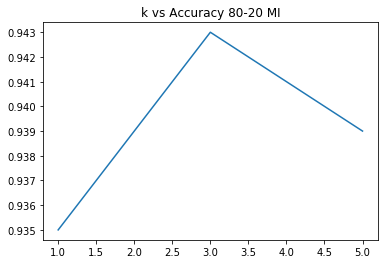

In [251]:
plt.plot([1,3,5],acculist8020mi)
plt.title("k vs Accuracy 80-20 MI")
plt.show()

#### 70-30 split

In [235]:
acculist7030mi = []

In [236]:
result70mik1 = knn(trainnormalised70mi,testnormalised30mi,1, train_index70)
result70mik3 = knn(trainnormalised70mi,testnormalised30mi,3, train_index70)
result70mik5 = knn(trainnormalised70mi,testnormalised30mi,5, train_index70)


100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1220.05it/s]

100%|████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 1034.69it/s]

100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:01<00:00, 954.63it/s]


### Calculate Accuracy 70-30

In [237]:
acculist7030mi.append(accuracy(test_data30,result70mik1,docsdic))
acculist7030mi.append(accuracy(test_data30,result70mik3,docsdic))
acculist7030mi.append(accuracy(test_data30,result70mik5,docsdic))

In [238]:
print("K=1")
print("Accuracy with MI feature selection over 70-30 split",acculist7030mi[0])
confusion_matrix(docsdic,result70mik1,test_data30)

K=1
Accuracy with MI feature selection over 80-20 split 0.9286666666666666


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,291,3,16,12,8
rec.sport.hockey,2,290,6,8,9
sci.med,8,3,275,7,9
sci.space,0,3,5,268,5
talk.politics.misc,1,1,1,5,269


In [239]:
print("K=3")
print("Accuracy with MI feature selection over 70-30 split",acculist7030mi[1])
confusion_matrix(docsdic,result70mik3,test_data30)

K=3
Accuracy with MI feature selection over 70-30 split 0.9333333333333333


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,296,2,16,14,10
rec.sport.hockey,1,293,3,9,10
sci.med,5,4,279,7,10
sci.space,0,1,4,266,4
talk.politics.misc,0,0,1,4,266


In [240]:
print("K=5")
print("Accuracy with MI feature selection over 70-30 split",acculist7030mi[2])
confusion_matrix(docsdic,result70mik5,test_data30)

K=5
Accuracy with MI feature selection over 70-30 split 0.9306666666666666


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,298,2,17,22,10
rec.sport.hockey,0,296,3,8,11
sci.med,4,1,280,6,11
sci.space,0,1,2,261,7
talk.politics.misc,0,0,1,3,261


### K vs Accuracy for 70-30 split MI K = 1,3,5

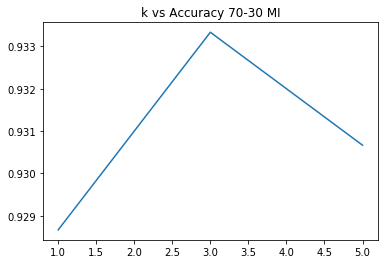

In [250]:
plt.plot([1,3,5],acculist7030mi)
plt.title("k vs Accuracy 70-30 MI")
plt.show()

#### 50-50 split

In [242]:
acculist5050mi = []

In [241]:
result50mik1 = knn(trainnormalised50mi,testnormalised50mi,1, train_index50)
result50mik3 = knn(trainnormalised50mi,testnormalised50mi,3, train_index50)
result50mik5 = knn(trainnormalised50mi,testnormalised50mi,5, train_index50)


100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1023.65it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1144.39it/s]

100%|████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:02<00:00, 1121.21it/s]


### Calculate Accuracy for 50-50 split

In [243]:
acculist5050mi.append(accuracy(test_data50,result50mik1,docsdic))
acculist5050mi.append(accuracy(test_data50,result50mik3,docsdic))
acculist5050mi.append(accuracy(test_data50,result50mik5,docsdic))

In [244]:
print("K=1")
print("Accuracy with MI feature selection over 50-50 split",acculist5050mi[0])
confusion_matrix(docsdic,result50mik1,test_data50)

K=1
Accuracy with MI feature selection over 50-50 split 0.8992


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,478,12,27,32,22
rec.sport.hockey,9,481,15,19,23
sci.med,9,1,436,9,13
sci.space,7,5,14,421,11
talk.politics.misc,1,1,12,21,432


In [247]:
print("K=3")
print("Accuracy with MI feature selection over 50-50 split",acculist5050mi[1])
confusion_matrix(docsdic,result50mik3,test_data50)

K=3
Accuracy with MI feature selection over 50-50 split 0.9036


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,488,9,38,37,26
rec.sport.hockey,5,488,15,20,21
sci.med,6,1,435,7,13
sci.space,3,1,8,417,10
talk.politics.misc,2,1,8,21,431


In [246]:
print("K=5")
print("Accuracy with MI feature selection over 50-50 split",acculist5050mi[2])
confusion_matrix(docsdic,result50mik5,test_data50)

K=5
Accuracy with MI feature selection over 50-50 split 0.91


,comp.graphics-pred,rec.sport.hockey-pred,sci.med-pred,sci.space-pred,talk.politics.misc-pred
comp.graphics,488,4,31,38,29
rec.sport.hockey,6,493,9,24,19
sci.med,5,1,451,8,11
sci.space,4,2,6,411,10
talk.politics.misc,1,0,7,21,432


### K vs Accuracy for 50-50 split , K = 1,3,5

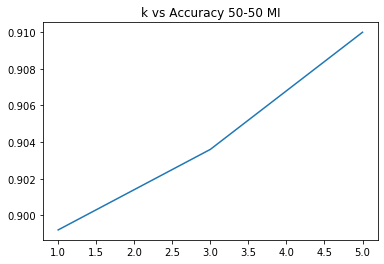

In [252]:
plt.plot([1,3,5],acculist5050mi)
plt.title("k vs Accuracy 50-50 MI")
plt.show()

### K vs Accuracy for all split of data with MI

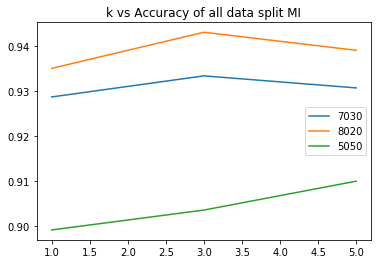

In [265]:
plt.plot([1,3,5],acculist7030mi, label = '7030')
plt.plot([1,3,5],acculist8020mi, label = '8020')
plt.plot([1,3,5],acculist5050mi, label = '5050')
plt.legend()
plt.title("k vs Accuracy of all data split MI")
plt.show()

### K vs Accuracy for 80-20 set for TF-IDF and MI

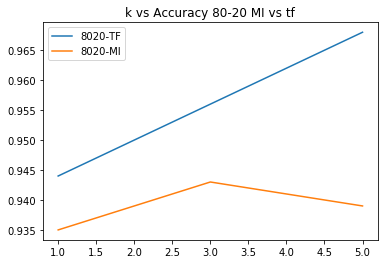

In [267]:
plt.plot([1,3,5],acculist8020, label = '8020-TF')
plt.plot([1,3,5],acculist8020mi, label = '8020-MI')
plt.legend()
plt.title("k vs Accuracy 80-20 MI vs tf")
plt.show()

### K vs Accuracy for 70-30 set for TF-IDF and MI

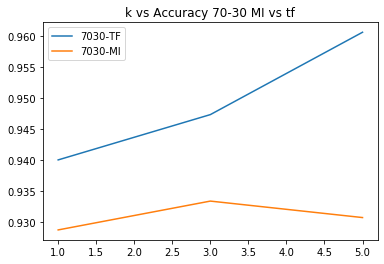

In [268]:
plt.plot([1,3,5],acculist7030, label = '7030-TF')
plt.plot([1,3,5],acculist7030mi, label = '7030-MI')
plt.legend()
plt.title("k vs Accuracy 70-30 MI vs tf")
plt.show()

### K vs Accuracy for 50-50 set for TF-IDF and MI

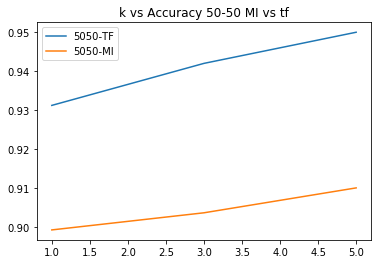

In [269]:
plt.plot([1,3,5],acculist5050, label = '5050-TF')
plt.plot([1,3,5],acculist5050mi, label = '5050-MI')
plt.legend()
plt.title("k vs Accuracy 50-50 MI vs tf")
plt.show()